Import image, process, return the stl file of 3d model

In [3]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from ipywidgets import FileUpload

# Create an upload widget
upload = FileUpload(
    accept='.png, .jpg, .jpeg',  # accepted file extensions
    multiple=False  # allow only one file at a time
)
display(upload)

# Function to display the uploaded image
def display_uploaded_image(change):
    if upload.value:
        # Get the first (and only) uploaded file
        file_name = list(upload.value.keys())[0]
        file_data = upload.value[file_name]['content']
        
        # Display the image
        display(Image(data=file_data))
        
        # Read the image with OpenCV
        nparr = np.frombuffer(file_data, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        
        # Convert BGR to RGB for matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Display with matplotlib
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

# Register the callback function
upload.observe(display_uploaded_image, names='value')

FileUpload(value=(), accept='.png, .jpg, .jpeg', description='Upload')

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from ipywidgets import FileUpload, Dropdown, VBox

# Create an upload widget
upload = FileUpload(
    accept='.png, .jpg, .jpeg',  # accepted file extensions
    multiple=False  # allow only one file at a time
)
display(upload)

# Dropdown for color map selection
colormap_dropdown = Dropdown(
    options=[
        ('Jet', cv2.COLORMAP_JET),
        ('Hot', cv2.COLORMAP_HOT),
        ('Cool', cv2.COLORMAP_COOL),
        ('Viridis', cv2.COLORMAP_VIRIDIS),
        ('Plasma', cv2.COLORMAP_PLASMA),
        ('Magma', cv2.COLORMAP_MAGMA),
        ('Inferno', cv2.COLORMAP_INFERNO),
        ('Autumn', cv2.COLORMAP_AUTUMN),
        ('Winter', cv2.COLORMAP_WINTER),
        ('Spring', cv2.COLORMAP_SPRING),
        ('Summer', cv2.COLORMAP_SUMMER),
    ],
    value=cv2.COLORMAP_JET,
    description='Colormap:'
)
display(colormap_dropdown)

# Function to apply colormap and display
def display_uploaded_image(change):
    if upload.value:
        # Get uploaded content properly by checking the structure
        file_info = list(upload.value.values())[0] if isinstance(upload.value, dict) else upload.value[0]
        
        if isinstance(file_info, dict) and 'content' in file_info:
            file_data = file_info['content']
        else:
            print("Error: Unable to read uploaded file data.")
            return
        
        # Display the original image
        display(Image(data=file_data))
        
        # Read the image with OpenCV
        nparr = np.frombuffer(file_data, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        
        if img is None:
            print("Error: Unable to read image. Make sure the file is a valid image.")
            return
        
        # Convert to grayscale to apply colormap
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply selected colormap
        colormap = colormap_dropdown.value
        color_mapped_img = cv2.applyColorMap(gray_img, colormap)
        
        # Convert BGR to RGB for matplotlib
        img_rgb = cv2.cvtColor(color_mapped_img, cv2.COLOR_BGR2RGB)
        
        # Display the color-mapped image
        plt.figure(figsize=(10, 8))
        plt.title("Colormap Applied")
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

# Register the callback function
upload.observe(display_uploaded_image, names='value')


FileUpload(value=(), accept='.png, .jpg, .jpeg', description='Upload')

Dropdown(description='Colormap:', options=(('Jet', 2), ('Hot', 11), ('Cool', 8), ('Viridis', 16), ('Plasma', 1…

color segmentation: Kmeans clustering

In [24]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def color_segmentation(image_path):
    # Load the image (replace 'path/to/image.jpg' with your image path)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Check the path.")

    # Convert the image from BGR to Lab color space
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Reshape the image to a 2D array of pixels and 3 color values (L, a, b)
    pixel_values = img_lab.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define the number of clusters (this determines the number of layers)
    k = 4  # Adjust based on how many layers you want
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pixel_values)
    centers = np.uint8(kmeans.cluster_centers_)

    # Map the centers to the pixels to create the segmented image
    segmented_data = centers[labels.flatten()]
    segmented_img = segmented_data.reshape(img_lab.shape)

    # Optionally, convert back to RGB for display
    segmented_img_rgb = cv2.cvtColor(segmented_img, cv2.COLOR_LAB2RGB)

    # Display the segmented image
    plt.figure(figsize=(10, 8))
    plt.imshow(segmented_img_rgb)
    plt.title("Segmented Image Using K-means Clustering")
    plt.axis("off")
    plt.show()


estimate a depth map from a single 2D image using a pretrained model (MiDaS) and then segment that depth map into layers. In this example, we first compute a normalized depth map and then partition it into (for example) three layers—from foreground to background—by dividing the depth range into intervals.

In [17]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [20]:
import ssl
# WARNING: Disabling SSL verification can expose you to security risks.
# Only use this workaround if you're in a trusted environment.
ssl._create_default_https_context = ssl._create_unverified_context

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt


def depth_segmentation(image_path):
    # -------------------------------
    # 1. Load the MiDaS model
    # -------------------------------
    model_type = "MiDaS_small"  # Use the small model for faster performance
    try:
        midas = torch.hub.load("intel-isl/MiDaS", model_type)
    except Exception as e:
        raise RuntimeError("Error loading MiDaS model. Check your internet connection or SSL certificates.") from e

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    # Load the appropriate transforms for the chosen model
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    if model_type == "MiDaS_small":
        transform = midas_transforms.small_transform
    else:
        transform = midas_transforms.default_transform

    # -------------------------------
    # 2. Load and Preprocess the Image
    # -------------------------------
    # Replace with your image path
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Check the path!")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply the transform and move to the chosen device
    input_batch = transform(img_rgb).to(device)

    # -------------------------------
    # 3. Generate the Depth Map
    # -------------------------------
    with torch.no_grad():
        prediction = midas(input_batch)

    # Resize the depth map to match the original image size
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    # Convert depth prediction to a numpy array
    depth_map = prediction.cpu().numpy()

    # Normalize the depth map to the range 0-1
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)

    # Display the normalized depth map using a colormap
    plt.figure(figsize=(8, 6))
    plt.imshow(normalized_depth, cmap='plasma')
    plt.title("Estimated Depth Map")
    plt.axis('off')
    plt.show()

    # -------------------------------
    # 4. Segment the Depth Map into Layers
    # -------------------------------
    # Decide on the number of layers (e.g., foreground, midground, background)
    num_layers = 3
    thresholds = np.linspace(0, 1, num_layers + 1)

    layers = {}
    for i in range(num_layers):
        # Create a binary mask for the current depth interval
        mask = (normalized_depth >= thresholds[i]) & (normalized_depth < thresholds[i+1])
        layers[f'Layer {i+1}'] = mask

    # -------------------------------
    # 5. Visualize the Layers
    # -------------------------------
    fig, axes = plt.subplots(1, num_layers, figsize=(15, 5))
    for i, (layer_name, mask) in enumerate(layers.items()):
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(layer_name)
        axes[i].axis('off')
    plt.suptitle("Depth-Based Layers")
    plt.show()


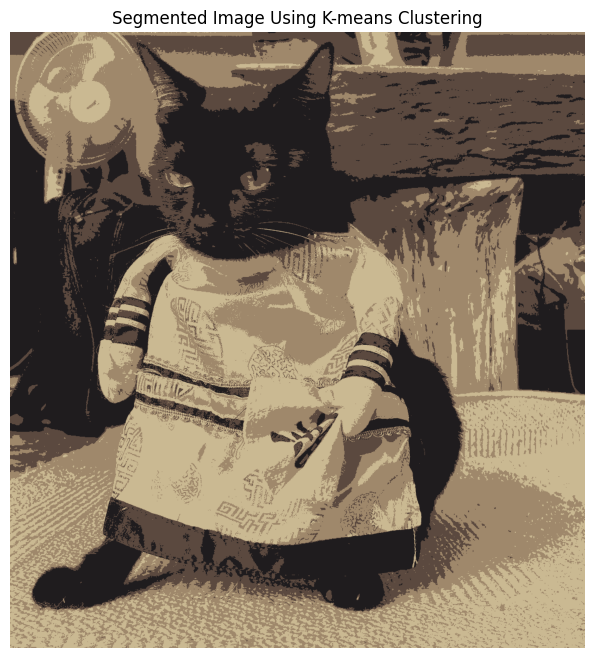

Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


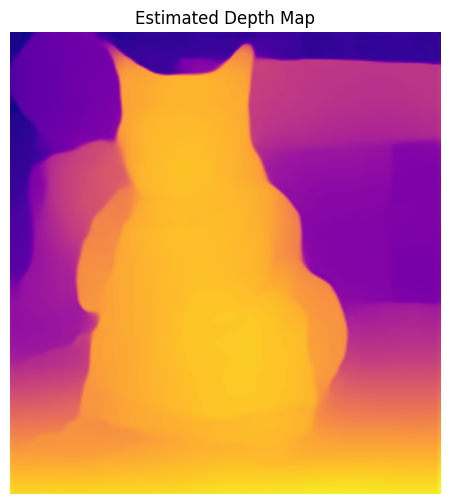

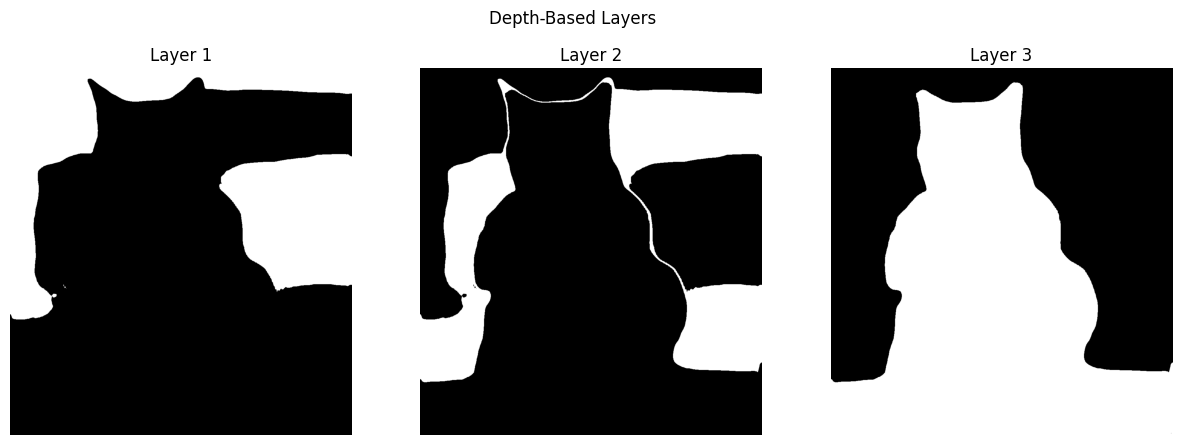

In [25]:
color_segmentation("cat_image.jpg")
depth_segmentation("cat_image.jpg")


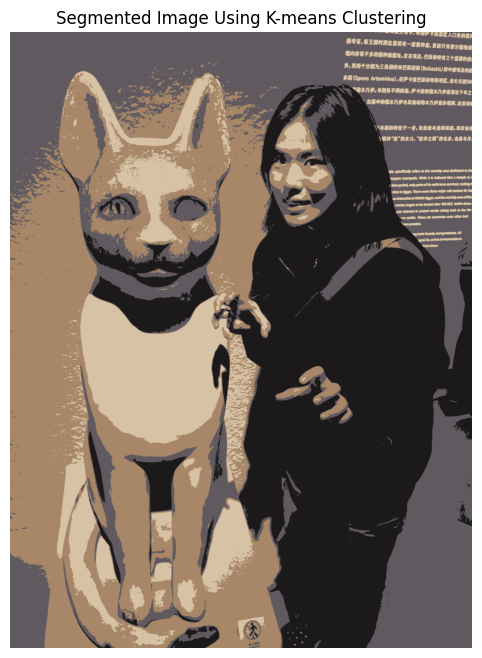

Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


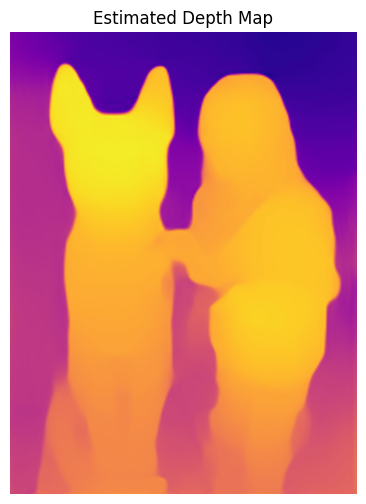

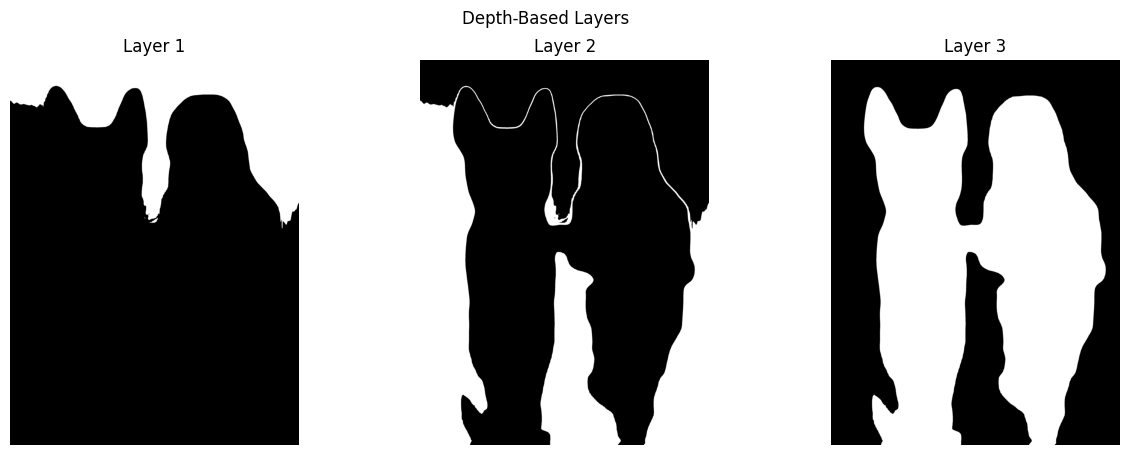

In [26]:
color_segmentation("michelle_cat.jpg")
depth_segmentation("michelle_cat.jpg")

In [28]:
import ssl
# WARNING: Disabling SSL verification can expose you to security risks.
# Only use this workaround if you're in a trusted environment.
ssl._create_default_https_context = ssl._create_unverified_context

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

def process_image_object_depth(image_path, detection_threshold=0.8):
    """
    Processes an input image by estimating a depth map using MiDaS,
    runs object detection using Faster R-CNN, and extracts depth regions for each detected object.
    
    Parameters:
      image_path (str): Path to the input image.
      detection_threshold (float): Confidence threshold for object detection.
    """
    # 1. Load the input image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Check the path!")
    # Convert BGR (OpenCV default) to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2. Load and run MiDaS for depth estimation
    model_type = "MiDaS_small"  # Using the small version for speed
    try:
        midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
    except Exception as e:
        raise RuntimeError("Error loading MiDaS model. Check your internet connection or SSL certificates.") from e

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
    if model_type == "MiDaS_small":
        transform_midas = midas_transforms.small_transform
    else:
        transform_midas = midas_transforms.default_transform

    input_batch = transform_midas(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
    # Resize the depth map to match the input image size
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    depth_map = prediction.cpu().numpy()
    # Normalize the depth map for visualization (0-1 range)
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)
    
    # 3. Run object detection with Faster R-CNN
    detector = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    detector.to(device)
    detector.eval()
    # Preprocess image for detection
    transform_detector = transforms.Compose([
        transforms.ToTensor()
    ])
    input_tensor = transform_detector(Image.fromarray(img_rgb)).to(device)
    with torch.no_grad():
        detections = detector([input_tensor])[0]
    
    # Extract bounding boxes, scores, and labels
    boxes = detections['boxes'].cpu().numpy()
    scores = detections['scores'].cpu().numpy()
    labels = detections['labels'].cpu().numpy()
    
    # Filter detections using the confidence threshold
    valid_indices = np.where(scores > detection_threshold)[0]
    boxes = boxes[valid_indices]
    scores = scores[valid_indices]
    labels = labels[valid_indices]
    
    # 4. Visualize the depth map with detected object bounding boxes overlaid
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_depth, cmap='plasma')
    ax = plt.gca()
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='cyan', linewidth=2)
        ax.add_patch(rect)
    plt.title("Depth Map with Detected Objects")
    plt.axis('off')
    plt.show()
    
    # 5. For each detected object, display its corresponding depth region
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        obj_depth = normalized_depth[y1:y2, x1:x2]
        plt.figure(figsize=(4, 4))
        plt.imshow(obj_depth, cmap='plasma')
        plt.title(f"Object {i+1} Depth")
        plt.axis('off')
        plt.show()



Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


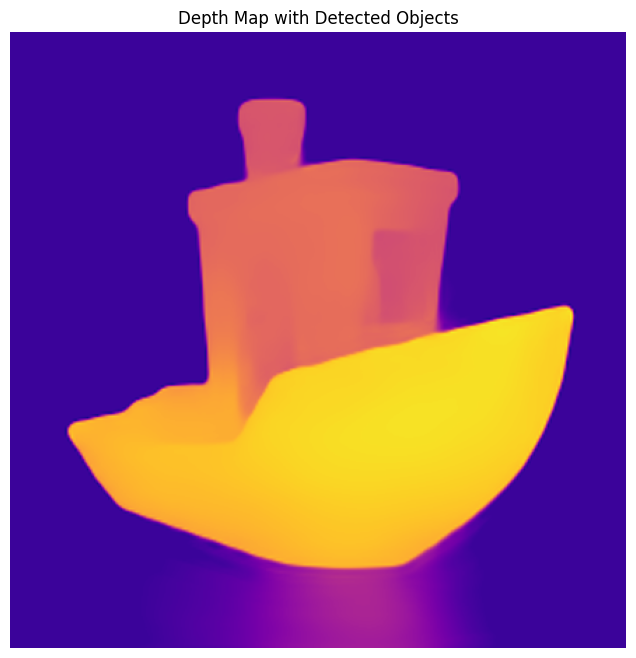

In [31]:

# Example usage:
process_image_object_depth("3dbenchy.png", detection_threshold=0.8)

In [33]:
import ssl
# WARNING: Disabling SSL verification can expose you to security risks.
# Only use this workaround if you're in a trusted environment.
ssl._create_default_https_context = ssl._create_unverified_context

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from stl import mesh  # requires: pip install numpy-stl

def process_image_and_get_depth(image_path, detection_threshold=0.8):
    """
    Loads an image and computes a normalized depth map using MiDaS.
    Returns the normalized depth map and the RGB image.
    """
    # 1. Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Check the path!")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2. Load and run MiDaS for depth estimation
    model_type = "MiDaS_small"  # Using the small model for speed
    try:
        midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
    except Exception as e:
        raise RuntimeError("Error loading MiDaS model. Check your internet connection or SSL certificates.") from e

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
    transform_midas = midas_transforms.small_transform if model_type == "MiDaS_small" else midas_transforms.default_transform

    input_batch = transform_midas(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
    # Resize the depth map to match the input image size
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    depth_map = prediction.cpu().numpy()

    # Normalize the depth map to the range 0-1
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)
    
    # Depending on your application, if MiDaS outputs "near" as high values,
    # then normalized_depth already has far objects (deep) near 0 and close objects near 1.
    # If you need to invert it, uncomment the next line:
    # normalized_depth = 1 - normalized_depth
    
    return normalized_depth, img_rgb

def depth_map_to_stl(normalized_depth, scale=10, stl_filename="output.stl", downscale_factor=1):
    """
    Converts a 2D normalized depth map (height map) into a 3D mesh and saves it as an STL file.
    
    Parameters:
      normalized_depth (ndarray): 2D array of depth values in [0,1].
      scale (float): Factor to scale the height (z-axis) differences.
      stl_filename (str): Output STL file name.
      downscale_factor (int): Factor to downscale the depth map for mesh generation.
    """
    # Optionally downscale the depth map for faster processing
    if downscale_factor != 1:
        new_width = normalized_depth.shape[1] // downscale_factor
        new_height = normalized_depth.shape[0] // downscale_factor
        normalized_depth = cv2.resize(normalized_depth, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    H, W = normalized_depth.shape
    vertices = []
    faces = []
    
    # Create a grid of vertices. Each vertex's z-coordinate is the depth value scaled.
    for i in range(H):
        for j in range(W):
            x = j
            y = i
            z = normalized_depth[i, j] * scale
            vertices.append([x, y, z])
    vertices = np.array(vertices)
    
    # Helper to compute the 1D index from 2D grid coordinates
    def idx(i, j):
        return i * W + j
    
    # Create faces (two triangles per grid cell)
    for i in range(H - 1):
        for j in range(W - 1):
            v1 = idx(i, j)
            v2 = idx(i, j + 1)
            v3 = idx(i + 1, j)
            v4 = idx(i + 1, j + 1)
            faces.append([v1, v2, v3])
            faces.append([v3, v2, v4])
    faces = np.array(faces)
    
    # Create the mesh using numpy-stl
    stl_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, face in enumerate(faces):
        for j in range(3):
            stl_mesh.vectors[i][j] = vertices[face[j], :]
    
    stl_mesh.save(stl_filename)
    print("STL file saved as", stl_filename)

def process_image_and_generate_stl(image_path, detection_threshold=0.8, scale=10, stl_filename="output.stl", downscale_factor=1):
    """
    Processes the image to generate a depth map and then converts that into a 3D mesh saved as an STL file.
    
    Parameters:
      image_path (str): Path to the input image.
      detection_threshold (float): (Unused here) For object detection threshold if needed.
      scale (float): Scale factor for converting normalized depth to height.
      stl_filename (str): Output STL file name.
      downscale_factor (int): Factor to downscale the depth map before mesh generation.
    """
    normalized_depth, img_rgb = process_image_and_get_depth(image_path, detection_threshold)
    
    # Visualize the normalized depth map (optional)
    plt.figure(figsize=(8, 6))
    plt.imshow(normalized_depth, cmap='plasma')
    plt.title("Normalized Depth Map")
    plt.axis('off')
    plt.show()
    
    # Generate the STL file from the depth map
    depth_map_to_stl(normalized_depth, scale, stl_filename, downscale_factor)




Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


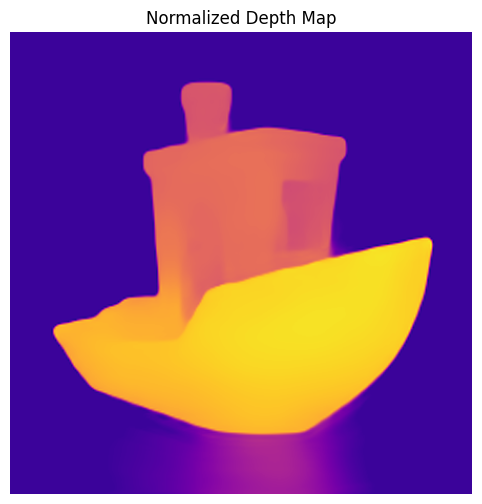

STL file saved as 3dbenchy_depth_model.stl


In [34]:
# Example usage:
process_image_and_generate_stl(
    "3dbenchy.png", 
    detection_threshold=0.8, 
    scale=10, 
    stl_filename="3dbenchy_depth_model.stl", 
    downscale_factor=4  # Adjust downscale factor as needed (higher = coarser mesh)
)

In [35]:
import ssl
# WARNING: Disabling SSL verification can expose you to security risks.
# Only use this workaround if you're in a trusted environment.
ssl._create_default_https_context = ssl._create_unverified_context

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from stl import mesh  # requires: pip install numpy-stl

def process_image_and_get_depth(image_path):
    """
    Loads an image and computes a normalized depth map using MiDaS.
    Returns the normalized depth map and the RGB image.
    """
    # 1. Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Check the path!")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2. Load and run MiDaS for depth estimation
    model_type = "MiDaS_small"  # Using the small model for speed
    try:
        midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
    except Exception as e:
        raise RuntimeError("Error loading MiDaS model. Check your internet connection or SSL certificates.") from e

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
    transform_midas = midas_transforms.small_transform if model_type == "MiDaS_small" else midas_transforms.default_transform

    input_batch = transform_midas(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
    # Resize the depth map to match the input image size
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    depth_map = prediction.cpu().numpy()

    # Normalize the depth map to the range 0-1
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)
    
    # Optionally invert the depth map if needed:
    # normalized_depth = 1 - normalized_depth
    
    return normalized_depth, img_rgb

def depth_map_to_stl_solid(normalized_depth, scale=10, stl_filename="output.stl", downscale_factor=1):
    """
    Converts a 2D normalized depth map (height map) into a closed 3D mesh and saves it as an STL file.
    The resulting model has a top surface (from the depth map), a flat bottom at z=0,
    and side walls to create a watertight (printable) object.
    
    Parameters:
      normalized_depth (ndarray): 2D array of depth values in [0,1].
      scale (float): Factor to scale the height (z-axis) differences.
      stl_filename (str): Output STL file name.
      downscale_factor (int): Factor to downscale the depth map for mesh generation.
    """
    # Optionally downscale the depth map to reduce mesh complexity
    if downscale_factor != 1:
        new_width = normalized_depth.shape[1] // downscale_factor
        new_height = normalized_depth.shape[0] // downscale_factor
        normalized_depth = cv2.resize(normalized_depth, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    H, W = normalized_depth.shape
    
    # Create top surface vertices: grid positions (x, y) with z = normalized_depth * scale.
    top_vertices = np.zeros((H, W, 3))
    for i in range(H):
        for j in range(W):
            top_vertices[i, j] = [j, i, normalized_depth[i, j] * scale]
    
    # Create bottom surface vertices (flat at z=0)
    bottom_vertices = np.zeros((H, W, 3))
    for i in range(H):
        for j in range(W):
            bottom_vertices[i, j] = [j, i, 0]
    
    # Flatten vertices: top first, then bottom.
    top_vertices_flat = top_vertices.reshape(-1, 3)
    bottom_vertices_flat = bottom_vertices.reshape(-1, 3)
    total_top = top_vertices_flat.shape[0]  # equals H*W
    all_vertices = np.vstack([top_vertices_flat, bottom_vertices_flat])
    
    faces = []

    # 1. Top surface faces (two triangles per grid cell)
    for i in range(H - 1):
        for j in range(W - 1):
            v1 = i * W + j
            v2 = i * W + (j + 1)
            v3 = (i + 1) * W + j
            v4 = (i + 1) * W + (j + 1)
            faces.append([v1, v2, v3])
            faces.append([v3, v2, v4])
    
    # 2. Bottom surface faces (use bottom vertices; reverse order so normals face downward)
    offset = total_top
    for i in range(H - 1):
        for j in range(W - 1):
            b1 = offset + i * W + j
            b2 = offset + i * W + (j + 1)
            b3 = offset + (i + 1) * W + j
            b4 = offset + (i + 1) * W + (j + 1)
            faces.append([b1, b3, b2])
            faces.append([b3, b4, b2])
    
    # 3. Side walls: Create quads along the boundaries (split into two triangles each)
    # Top edge (i=0)
    i = 0
    for j in range(W - 1):
        top1 = i * W + j
        top2 = i * W + (j + 1)
        bot1 = offset + i * W + j
        bot2 = offset + i * W + (j + 1)
        faces.append([top1, bot1, top2])
        faces.append([top2, bot1, bot2])
    
    # Bottom edge (i = H-1)
    i = H - 1
    for j in range(W - 1):
        top1 = i * W + j
        top2 = i * W + (j + 1)
        bot1 = offset + i * W + j
        bot2 = offset + i * W + (j + 1)
        # Reverse ordering to keep normals outward
        faces.append([top2, bot1, top1])
        faces.append([top2, bot2, bot1])
    
    # Left edge (j=0)
    j = 0
    for i in range(H - 1):
        top1 = i * W + j
        top2 = (i + 1) * W + j
        bot1 = offset + i * W + j
        bot2 = offset + (i + 1) * W + j
        faces.append([top1, bot2, bot1])
        faces.append([top1, top2, bot2])
    
    # Right edge (j = W-1)
    j = W - 1
    for i in range(H - 1):
        top1 = i * W + j
        top2 = (i + 1) * W + j
        bot1 = offset + i * W + j
        bot2 = offset + (i + 1) * W + j
        faces.append([top2, bot1, top1])
        faces.append([top2, bot2, bot1])
    
    all_faces = np.array(faces)
    
    # Create the STL mesh using numpy-stl
    solid_mesh = mesh.Mesh(np.zeros(all_faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, face in enumerate(all_faces):
        for j in range(3):
            solid_mesh.vectors[i][j] = all_vertices[face[j], :]
    solid_mesh.save(stl_filename)
    print("STL file saved as", stl_filename)

def process_image_and_generate_stl(image_path, scale=10, stl_filename="output.stl", downscale_factor=1):
    """
    Processes the image to generate a depth map and then converts that into a closed 3D mesh
    saved as an STL file. The model has a top surface (from the depth map), a flat bottom, and side walls.
    
    Parameters:
      image_path (str): Path to the input image.
      scale (float): Scale factor for converting normalized depth to height.
      stl_filename (str): Output STL file name.
      downscale_factor (int): Factor to downscale the depth map before mesh generation.
    """
    normalized_depth, img_rgb = process_image_and_get_depth(image_path)
    
    # Visualize the normalized depth map (optional)
    plt.figure(figsize=(8, 6))
    plt.imshow(normalized_depth, cmap='plasma')
    plt.title("Normalized Depth Map")
    plt.axis('off')
    plt.show()
    
    # Generate the solid (watertight) STL file from the depth map
    depth_map_to_stl_solid(normalized_depth, scale, stl_filename, downscale_factor)




Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


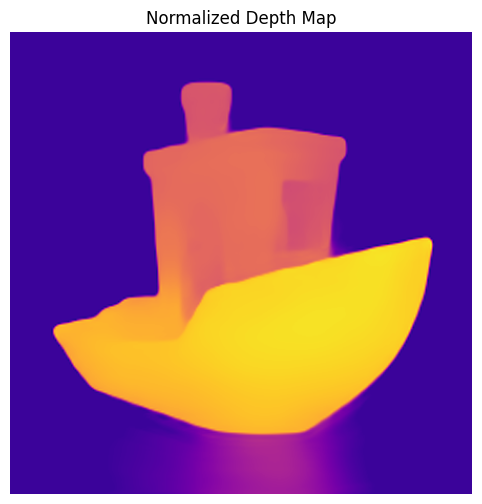

STL file saved as 3dbenchy_depth_model.stl


In [37]:
# Example usage:
process_image_and_generate_stl(
    "3dbenchy.png", 
    scale=10, 
    stl_filename="3dbenchy_depth_model.stl", 
    downscale_factor=4  # Adjust downscale factor as needed (higher = coarser mesh)
)

Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


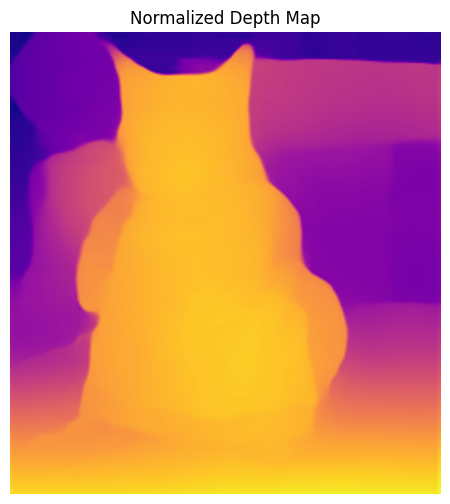

STL file saved as cat_depth_model.stl


In [38]:
process_image_and_generate_stl(
    "cat_image.jpg", 
    scale=10, 
    stl_filename="cat_depth_model.stl", 
    downscale_factor=10  # Adjust downscale factor as needed (higher = coarser mesh)
)

Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


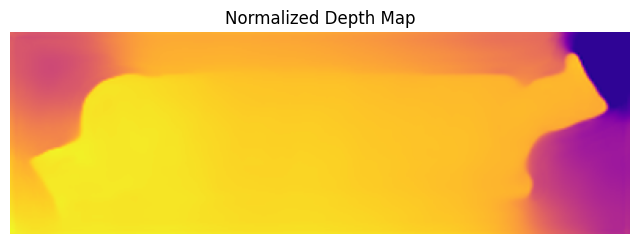

STL file saved as subway_depth_model.stl


In [40]:
process_image_and_generate_stl(
    "subway.png", 
    scale=10, 
    stl_filename="subway_depth_model.stl", 
    downscale_factor=10  # Adjust downscale factor as needed (higher = coarser mesh)
)

In [41]:
import ssl
# WARNING: Disabling SSL verification can expose you to security risks.
# Only use this workaround if you're in a trusted environment.
ssl._create_default_https_context = ssl._create_unverified_context

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from stl import mesh  # requires: pip install numpy-stl
from sklearn.cluster import KMeans

def process_image_and_get_depth(image_path):
    """
    Loads an image and computes a normalized depth map using MiDaS.
    Returns the normalized depth map and the RGB image.
    """
    # 1. Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Check the path!")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2. Load and run MiDaS for depth estimation
    model_type = "MiDaS_small"  # Using the small model for speed
    try:
        midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
    except Exception as e:
        raise RuntimeError("Error loading MiDaS model. Check your internet connection or SSL certificates.") from e

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
    transform_midas = midas_transforms.small_transform if model_type == "MiDaS_small" else midas_transforms.default_transform

    input_batch = transform_midas(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
    # Resize the depth map to match the input image size
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    depth_map = prediction.cpu().numpy()

    # Normalize the depth map to the range 0-1
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)
    
    # If necessary, invert the depth map (uncomment next line if "near" is high)
    # normalized_depth = 1 - normalized_depth
    
    return normalized_depth, img_rgb

def compute_detail_map(normalized_depth, img_rgb, depth_layers=3, num_color_clusters=3, detail_scale=1.0):
    """
    For each depth layer (as determined by thresholding normalized_depth),
    cluster the corresponding pixels in the color (Lab) space to derive a small height offset.
    
    Parameters:
      normalized_depth (ndarray): 2D array of normalized depth values [0,1].
      img_rgb (ndarray): Corresponding RGB image (same dimensions as normalized_depth).
      depth_layers (int): Number of depth layers to segment.
      num_color_clusters (int): Number of clusters for color segmentation per layer.
      detail_scale (float): Maximum height offset to add from color detail.
      
    Returns:
      detail_map (ndarray): 2D array of the same size with per-pixel offset values.
    """
    # Convert the RGB image to Lab for more perceptually uniform clustering
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    H, W = normalized_depth.shape
    detail_map = np.zeros((H, W), dtype=np.float32)
    thresholds = np.linspace(0, 1, depth_layers + 1)
    
    for i in range(depth_layers):
        # Create mask for the current depth layer
        mask = (normalized_depth >= thresholds[i]) & (normalized_depth < thresholds[i+1])
        indices = np.argwhere(mask)  # rows, cols where mask is True
        if len(indices) == 0:
            continue
        # Extract Lab values for these pixels and convert to float32
        lab_values = img_lab[mask].reshape(-1, 3).astype(np.float32)
        k = min(num_color_clusters, len(lab_values))
        if k < 2:
            continue  # not enough pixels to cluster
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(lab_values)
        # Normalize cluster labels to a small offset in [0, detail_scale]
        offsets = (labels.astype(np.float32) / (k - 1)) * detail_scale
        # Assign these offsets back to the detail map
        for (row, col), offset in zip(indices, offsets):
            detail_map[row, col] = offset
    return detail_map

def depth_map_to_stl_solid_with_details(normalized_depth, img_rgb, scale=10, stl_filename="output.stl",
                                        downscale_factor=1, num_color_clusters=3, detail_scale=1.0, depth_layers=3):
    """
    Converts a 2D normalized depth map (height map) into a closed 3D mesh (with subtle color-based detail)
    and saves it as an STL file.
    
    The resulting model has:
      - A top surface: height = normalized_depth * scale + detail offset (from color clustering)
      - A flat bottom (z=0)
      - Side walls connecting the top and bottom to form a watertight, printable object.
    
    Parameters:
      normalized_depth (ndarray): 2D depth map with values in [0,1].
      img_rgb (ndarray): Original RGB image (same dimensions as normalized_depth).
      scale (float): Scale factor for the overall depth (z-axis).
      stl_filename (str): Output STL file name.
      downscale_factor (int): Downscaling factor to reduce mesh resolution.
      num_color_clusters (int): Number of clusters for color segmentation per depth layer.
      detail_scale (float): Maximum additional height offset from color details.
      depth_layers (int): Number of depth layers for splitting the region for color analysis.
    """
    # Downscale both normalized_depth and img_rgb if requested
    if downscale_factor != 1:
        new_width = normalized_depth.shape[1] // downscale_factor
        new_height = normalized_depth.shape[0] // downscale_factor
        normalized_depth = cv2.resize(normalized_depth, (new_width, new_height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.resize(img_rgb, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    H, W = normalized_depth.shape
    # Compute a detail offset map based on color segmentation per depth layer
    detail_map = compute_detail_map(normalized_depth, img_rgb,
                                    depth_layers=depth_layers,
                                    num_color_clusters=num_color_clusters,
                                    detail_scale=detail_scale)
    
    # Create top surface vertices: use the refined height = depth * scale + detail offset.
    top_vertices = np.zeros((H, W, 3))
    for i in range(H):
        for j in range(W):
            top_vertices[i, j] = [j, i, normalized_depth[i, j] * scale + detail_map[i, j]]
    
    # Create bottom surface vertices (flat at z=0)
    bottom_vertices = np.zeros((H, W, 3))
    for i in range(H):
        for j in range(W):
            bottom_vertices[i, j] = [j, i, 0]
    
    # Flatten vertices: top first, then bottom.
    top_vertices_flat = top_vertices.reshape(-1, 3)
    bottom_vertices_flat = bottom_vertices.reshape(-1, 3)
    total_top = top_vertices_flat.shape[0]  # equals H * W
    all_vertices = np.vstack([top_vertices_flat, bottom_vertices_flat])
    
    faces = []
    # 1. Top surface faces (two triangles per grid cell)
    for i in range(H - 1):
        for j in range(W - 1):
            v1 = i * W + j
            v2 = i * W + (j + 1)
            v3 = (i + 1) * W + j
            v4 = (i + 1) * W + (j + 1)
            faces.append([v1, v2, v3])
            faces.append([v3, v2, v4])
    
    # 2. Bottom surface faces (use bottom vertices; reverse ordering so normals face downward)
    offset = total_top
    for i in range(H - 1):
        for j in range(W - 1):
            b1 = offset + i * W + j
            b2 = offset + i * W + (j + 1)
            b3 = offset + (i + 1) * W + j
            b4 = offset + (i + 1) * W + (j + 1)
            faces.append([b1, b3, b2])
            faces.append([b3, b4, b2])
    
    # 3. Side walls: build walls along the perimeter by connecting top and bottom edges.
    # Top edge (i=0)
    i = 0
    for j in range(W - 1):
        top1 = i * W + j
        top2 = i * W + (j + 1)
        bot1 = offset + i * W + j
        bot2 = offset + i * W + (j + 1)
        faces.append([top1, bot1, top2])
        faces.append([top2, bot1, bot2])
    
    # Bottom edge (i=H-1)
    i = H - 1
    for j in range(W - 1):
        top1 = i * W + j
        top2 = i * W + (j + 1)
        bot1 = offset + i * W + j
        bot2 = offset + i * W + (j + 1)
        faces.append([top2, bot1, top1])
        faces.append([top2, bot2, bot1])
    
    # Left edge (j=0)
    j = 0
    for i in range(H - 1):
        top1 = i * W + j
        top2 = (i + 1) * W + j
        bot1 = offset + i * W + j
        bot2 = offset + (i + 1) * W + j
        faces.append([top1, bot2, bot1])
        faces.append([top1, top2, bot2])
    
    # Right edge (j=W-1)
    j = W - 1
    for i in range(H - 1):
        top1 = i * W + j
        top2 = (i + 1) * W + j
        bot1 = offset + i * W + j
        bot2 = offset + (i + 1) * W + j
        faces.append([top2, bot1, top1])
        faces.append([top2, bot2, bot1])
    
    all_faces = np.array(faces)
    
    # Create the STL mesh using numpy-stl.
    solid_mesh = mesh.Mesh(np.zeros(all_faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, face in enumerate(all_faces):
        for j in range(3):
            solid_mesh.vectors[i][j] = all_vertices[face[j], :]
    solid_mesh.save(stl_filename)
    print("STL file saved as", stl_filename)

def process_image_and_generate_stl(image_path, scale=10, stl_filename="output.stl",
                                   downscale_factor=1, num_color_clusters=3, detail_scale=1.0, depth_layers=3):
    """
    Processes an image to obtain a depth map and then converts it into a 3D printable,
    watertight STL file. The top surface combines the overall depth (from MiDaS)
    and subtle color-based height details.
    
    Parameters:
      image_path (str): Path to the input image.
      scale (float): Overall scale factor for the depth map (z-axis).
      stl_filename (str): Name for the output STL file.
      downscale_factor (int): Factor to downscale the image for mesh generation.
      num_color_clusters (int): Number of color clusters per depth layer.
      detail_scale (float): Maximum additional height from color detail.
      depth_layers (int): Number of depth layers to process for color details.
    """
    normalized_depth, img_rgb = process_image_and_get_depth(image_path)
    
    # Optionally visualize the normalized depth map.
    plt.figure(figsize=(8, 6))
    plt.imshow(normalized_depth, cmap='plasma')
    plt.title("Normalized Depth Map")
    plt.axis('off')
    plt.show()
    
    # Generate the STL with integrated color-based detail offsets.
    depth_map_to_stl_solid_with_details(normalized_depth, img_rgb, scale, stl_filename,
                                          downscale_factor, num_color_clusters, detail_scale, depth_layers)


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


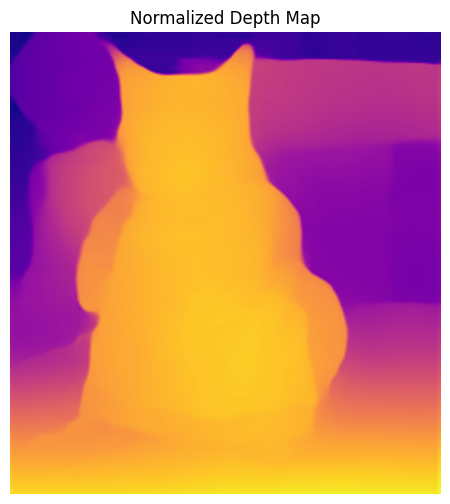

STL file saved as cat_depth_model_with_details.stl


In [42]:

# Example usage:
process_image_and_generate_stl(
    "cat_image.jpg", 
    scale=10, 
    stl_filename="cat_depth_model_with_details.stl", 
    downscale_factor=4,         # Higher values create a coarser mesh.
    num_color_clusters=3,       # Adjust per depth layer.
    detail_scale=1.0,           # Maximum height offset from color detail.
    depth_layers=3              # Number of depth layers for color analysis.
)


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


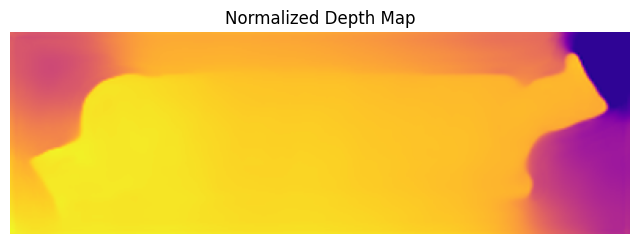

STL file saved as subway_depth_model_with_details.stl


In [43]:

# Example usage:
process_image_and_generate_stl(
    "subway.png", 
    scale=10, 
    stl_filename="subway_depth_model_with_details.stl", 
    downscale_factor=4,         # Higher values create a coarser mesh.
    num_color_clusters=3,       # Adjust per depth layer.
    detail_scale=1.0,           # Maximum height offset from color detail.
    depth_layers=3              # Number of depth layers for color analysis.
)


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


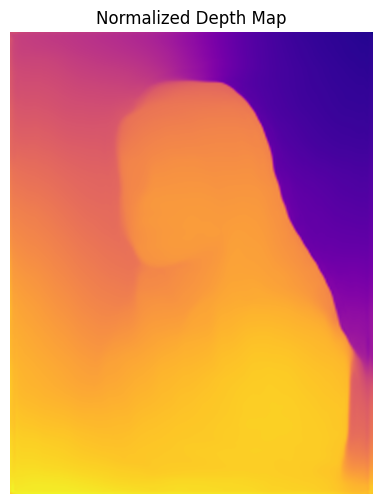

STL file saved as girl_figure_depth_model_with_details.stl


In [48]:

# Example usage:
process_image_and_generate_stl(
    "girl_figure.png", 
    scale=10, 
    stl_filename="girl_figure_depth_model_with_details.stl", 
    downscale_factor=1,         # Higher values create a coarser mesh.
    num_color_clusters=3,       # Adjust per depth layer.
    detail_scale=1.0,           # Maximum height offset from color detail.
    depth_layers=3              # Number of depth layers for color analysis.
)


In [51]:
import ssl
# WARNING: Disabling SSL verification can expose you to security risks.
# Only use this workaround if you're in a trusted environment.
ssl._create_default_https_context = ssl._create_unverified_context

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from stl import mesh  # requires: pip install numpy-stl
from sklearn.cluster import KMeans

def process_image_and_get_depth(image_path):
    """
    Loads an image and computes a normalized depth map using MiDaS.
    Returns the normalized depth map and the RGB image.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found. Check the path!")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    model_type = "MiDaS_small"
    try:
        midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
    except Exception as e:
        raise RuntimeError("Error loading MiDaS model. Check your internet connection or SSL certificates.") from e

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas.to(device)
    midas.eval()
    
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
    transform_midas = midas_transforms.small_transform if model_type == "MiDaS_small" else midas_transforms.default_transform

    input_batch = transform_midas(img_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    depth_map = prediction.cpu().numpy()
    depth_min, depth_max = depth_map.min(), depth_map.max()
    normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)
    
    # Uncomment the following line if MiDaS outputs "near" as high values
    # normalized_depth = 1 - normalized_depth
    
    return normalized_depth, img_rgb

def compute_detail_map(normalized_depth, img_rgb, depth_layers=3, num_color_clusters=3, detail_scale=1.0):
    """
    Computes a detail offset map from the image by clustering colors (in Lab space)
    for each depth layer.
    """
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    H, W = normalized_depth.shape
    detail_map = np.zeros((H, W), dtype=np.float32)
    thresholds = np.linspace(0, 1, depth_layers + 1)
    
    for i in range(depth_layers):
        mask = (normalized_depth >= thresholds[i]) & (normalized_depth < thresholds[i+1])
        indices = np.argwhere(mask)
        if len(indices) == 0:
            continue
        lab_values = img_lab[mask].reshape(-1, 3).astype(np.float32)
        k = min(num_color_clusters, len(lab_values))
        if k < 2:
            continue
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(lab_values)
        offsets = (labels.astype(np.float32) / (k - 1)) * detail_scale
        for (row, col), offset in zip(indices, offsets):
            detail_map[row, col] = offset
    return detail_map

def compute_combined_detail_map(normalized_depth, img_rgb, depth_layers=3, num_color_clusters=3, 
                                detail_scale=1.0, weight_lap=0.5):
    """
    Combines color-based detail (via clustering) with high-frequency detail extracted
    using a Laplacian filter.
    """
    detail_map_color = compute_detail_map(normalized_depth, img_rgb, depth_layers, num_color_clusters, detail_scale)
    
    # Compute high-frequency detail using Laplacian
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)
    laplacian = cv2.Laplacian(gray, cv2.CV_32F)
    laplacian_norm = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min())
    detail_map_lap = laplacian_norm * detail_scale
    
    combined_detail = (1 - weight_lap) * detail_map_color + weight_lap * detail_map_lap
    return combined_detail

def depth_map_to_stl_solid_with_details(normalized_depth, img_rgb, scale=10, stl_filename="output.stl",
                                        downscale_factor=1, num_color_clusters=3, detail_scale=1.0, 
                                        depth_layers=3, weight_lap=0.5, base_thickness=2):
    """
    Converts a 2D normalized depth map into a closed 3D mesh with detail offsets.
    The mesh includes a top surface (refined with local detail), a solid base (extruded
    downward by base_thickness), and side walls to produce a watertight, printable model.
    """
    # Downscale if desired
    if downscale_factor != 1:
        new_width = normalized_depth.shape[1] // downscale_factor
        new_height = normalized_depth.shape[0] // downscale_factor
        normalized_depth = cv2.resize(normalized_depth, (new_width, new_height), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.resize(img_rgb, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    H, W = normalized_depth.shape
    combined_detail = compute_combined_detail_map(normalized_depth, img_rgb, depth_layers, num_color_clusters, detail_scale, weight_lap)
    
    # Create top surface vertices: height = normalized_depth * scale + detail offset.
    top_vertices = np.zeros((H, W, 3))
    for i in range(H):
        for j in range(W):
            top_vertices[i, j] = [j, i, normalized_depth[i, j] * scale + combined_detail[i, j]]
    
    # Create bottom surface vertices: a solid flat base at z = -base_thickness.
    bottom_vertices = np.zeros((H, W, 3))
    for i in range(H):
        for j in range(W):
            bottom_vertices[i, j] = [j, i, -base_thickness]
    
    # Flatten the vertex arrays: top first, then bottom.
    top_vertices_flat = top_vertices.reshape(-1, 3)
    bottom_vertices_flat = bottom_vertices.reshape(-1, 3)
    total_top = top_vertices_flat.shape[0]
    all_vertices = np.vstack([top_vertices_flat, bottom_vertices_flat])
    
    faces = []
    # Top surface: two triangles per grid cell.
    for i in range(H - 1):
        for j in range(W - 1):
            v1 = i * W + j
            v2 = i * W + (j + 1)
            v3 = (i + 1) * W + j
            v4 = (i + 1) * W + (j + 1)
            faces.append([v1, v2, v3])
            faces.append([v3, v2, v4])
    
    # Bottom surface: use bottom vertices (reverse order so normals point outward).
    offset = total_top
    for i in range(H - 1):
        for j in range(W - 1):
            b1 = offset + i * W + j
            b2 = offset + i * W + (j + 1)
            b3 = offset + (i + 1) * W + j
            b4 = offset + (i + 1) * W + (j + 1)
            faces.append([b1, b3, b2])
            faces.append([b3, b4, b2])
    
    # Side walls: Connect the top and bottom surfaces along all four edges.
    # Top edge (i=0)
    i = 0
    for j in range(W - 1):
        top1 = i * W + j
        top2 = i * W + (j + 1)
        bot1 = offset + i * W + j
        bot2 = offset + i * W + (j + 1)
        faces.append([top1, bot1, top2])
        faces.append([top2, bot1, bot2])
    
    # Bottom edge (i=H-1)
    i = H - 1
    for j in range(W - 1):
        top1 = i * W + j
        top2 = i * W + (j + 1)
        bot1 = offset + i * W + j
        bot2 = offset + i * W + (j + 1)
        faces.append([top2, bot1, top1])
        faces.append([top2, bot2, bot1])
    
    # Left edge (j=0)
    j = 0
    for i in range(H - 1):
        top1 = i * W + j
        top2 = (i + 1) * W + j
        bot1 = offset + i * W + j
        bot2 = offset + (i + 1) * W + j
        faces.append([top1, bot2, bot1])
        faces.append([top1, top2, bot2])
    
    # Right edge (j=W-1)
    j = W - 1
    for i in range(H - 1):
        top1 = i * W + j
        top2 = (i + 1) * W + j
        bot1 = offset + i * W + j
        bot2 = offset + (i + 1) * W + j
        faces.append([top2, bot1, top1])
        faces.append([top2, bot2, bot1])
    
    all_faces = np.array(faces)
    
    # Create the STL mesh using numpy-stl and save it.
    solid_mesh = mesh.Mesh(np.zeros(all_faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, face in enumerate(all_faces):
        for j in range(3):
            solid_mesh.vectors[i][j] = all_vertices[face[j], :]
    solid_mesh.save(stl_filename)
    print("STL file saved as", stl_filename)

def process_image_and_generate_stl(image_path, scale=10, stl_filename="output.stl",
                                   downscale_factor=1, num_color_clusters=3, detail_scale=1.0, 
                                   depth_layers=3, weight_lap=0.5, base_thickness=2):
    """
    Processes an image to create a 3D printable, watertight STL file.
    The model includes an overall depth-based top surface with subtle local detail
    (from color and edge analysis) and a solid, extruded base.
    """
    normalized_depth, img_rgb = process_image_and_get_depth(image_path)
    
    # (Optional) Visualize the normalized depth map.
    plt.figure(figsize=(8, 6))
    plt.imshow(normalized_depth, cmap='plasma')
    plt.title("Normalized Depth Map")
    plt.axis('off')
    plt.show()
    
    depth_map_to_stl_solid_with_details(normalized_depth, img_rgb, scale, stl_filename,
                                          downscale_factor, num_color_clusters, detail_scale, 
                                          depth_layers, weight_lap, base_thickness)



Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/feng/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /Users/feng/.cache/torch/hub/intel-isl_MiDaS_master


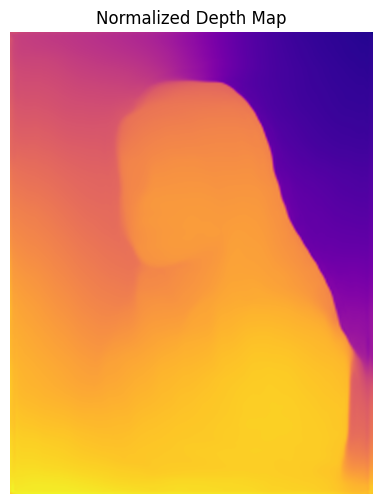

STL file saved as girl_figure_depth_model_detailed.stl


In [ ]:

# Example usage:
process_image_and_generate_stl(
    "girl_figure.png", 
    scale=10, 
    stl_filename="girl_figure_depth_model_detailed.stl", 
    downscale_factor=2,         # Use lower downscale factor to retain more details
    num_color_clusters=4,       # Increase clusters for finer color detail segmentation
    detail_scale=3.0,           # Adjust maximum detail height offset as needed
    depth_layers=3,             # Number of depth layers for color detail extraction
    weight_lap=0.5              # Blend weight between clustering detail and Laplacian detail
)
